# Thesis work--2
# A new method for multivariate regression problem for improving fitness in Genetic Programming

### Importing the libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from random import randrange, uniform
from sklearn.utils import check_random_state
from sklearn.metrics import mean_squared_error

### Global variables and functions for tuning

In [3]:
FEATURES = 2
NUMBER_OF_GENERATION = 20
ROWS = 300
POPULATION_SIZE = 400
TEST_SIZE = .2
NUMBER_OF_REGIONS = 3
formula = lambda X: X[:, 0]**2 - X[:, 1]**2 + X[:, 1] - 1

### Generating Training Samples

In [4]:
rng = check_random_state(0)
X = rng.uniform(-1, 1, ROWS).reshape(ROWS//FEATURES, FEATURES)
Y = formula(X)

### Splitting the dataset into the Training set and Test set

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

### Applying PCA

In [6]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 1)
#print(X_train)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
explained_variance = pca.explained_variance_ratio_
#print(X_train_pca)
#print(X_test_pca)
# print(np.shape(X_train),np.shape(X_test))
#print(explained_variance)

### Calculating DV

In [7]:
# sort X_train_pca and y_train by index
sorted_indexes = np.argsort(X_train_pca,axis=0)
sorted_x_train_pca = X_train_pca[sorted_indexes]
sorted_y_train = y_train[sorted_indexes]

# Finding Change of Slope
slope1 = []
slope2 = []
for itr in range(1,len(sorted_x_train_pca)):
    slope1.append((sorted_y_train[itr]-sorted_y_train[itr-1])/(sorted_x_train_pca[itr]-sorted_x_train_pca[itr-1]))
for itr in range(1,len(slope1)):
    slope2.append((slope1[itr]-slope1[itr-1])/(sorted_x_train_pca[itr]-sorted_x_train_pca[itr-1]))

# normalize slope2 
normalized_slope2 = (slope2-min(slope2))/(max(slope2)-min(slope2))

# Calculating Quantiles
normalized_slope2 = np.reshape(normalized_slope2,len(normalized_slope2))
quantile_ranges = pd.qcut(normalized_slope2,NUMBER_OF_REGIONS,labels=False,retbins=True)
quantile_ranges = quantile_ranges[1]

# Adding the difficult Vectors
difficult_points = {}
for q_ind in range(NUMBER_OF_REGIONS):
    low = quantile_ranges[q_ind]
    high = quantile_ranges[q_ind+1]
    difficult_points[q_ind] = []
    for n_ind in range(0,len(normalized_slope2)):
        if normalized_slope2[n_ind] >= low and normalized_slope2[n_ind] <= high:
            difficult_points[q_ind].append(n_ind)
print(difficult_points)

{0: [2, 3, 7, 10, 12, 14, 19, 22, 24, 25, 29, 31, 33, 35, 37, 41, 44, 49, 51, 53, 54, 56, 62, 64, 67, 72, 74, 78, 79, 82, 84, 86, 90, 94, 97, 99, 101, 103, 110, 113], 1: [0, 1, 5, 9, 11, 17, 18, 27, 36, 40, 46, 47, 48, 58, 59, 60, 65, 66, 69, 70, 75, 76, 79, 81, 87, 88, 89, 91, 92, 95, 98, 105, 106, 107, 108, 111, 114, 115, 116, 117], 2: [4, 6, 8, 11, 13, 15, 16, 20, 21, 23, 26, 28, 30, 32, 34, 38, 39, 42, 43, 45, 50, 52, 55, 57, 61, 63, 68, 71, 73, 77, 80, 83, 85, 93, 96, 100, 102, 104, 109, 112]}


### Training of converted PCA

In [8]:
from gplearn.genetic import SymbolicRegressor
est_gp = SymbolicRegressor(population_size=POPULATION_SIZE,
                           generations=NUMBER_OF_GENERATION, stopping_criteria=0.01,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.01, random_state=0)


### Getting the different regions of difficulty level

In [9]:
# Hard to evolve points
hard_to_evolve_x = X_train_pca[difficult_points[0]]
hard_to_evolve_y = y_train[difficult_points[0]]

# Medium to evolve points
medium_to_evolve_x = X_train_pca[difficult_points[1]]
medium_to_evolve_y = y_train[difficult_points[1]]

# Easy to evolve points
easy_to_evolve_x = X_train_pca[difficult_points[2]]
easy_to_evolve_y = y_train[difficult_points[2]]


### Feed the system hard to evolve points first

In [10]:
est_gp.fit(hard_to_evolve_x,hard_to_evolve_y)
print(est_gp._program)

    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    46.62 81.35580984963467       15 0.5226602104681045 0.18657394344567546      9.29s
   1    11.84 2.370129450981327        7 0.40371018765547817 0.5651704149650335     11.54s
   2      8.9 1.135546949227627        7 0.38387045665789415 0.7437279939432903     11.41s
   3     7.56 1.0849293438962144        7 0.33174376492399565 1.2128682195483762     10.91s
   4     7.03 1.0194092229457348        7 0.36454508913297823 0.9176563016675334     10.74s
   5     6.76 1.0210115269863218        7 0.36391414122224686 0.7162377017055817     10.29s
   6     6.55 1.1694955588406741        7 0.33913845243411234 0.9214245184627423      9.31s
   7     6.42 1.450040287899351        7 0.3461359284671352 0.8584472341655367      8.56s
   8     5.98 1.10015337

### Feed the system Medium to evolve points keeping the current modal state appending generation by current generation

In [11]:
est_gp.set_params(generations=NUMBER_OF_GENERATION*2, warm_start=True)
est_gp.fit(medium_to_evolve_x,medium_to_evolve_y)
print(est_gp._program)

    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
  20     5.13 0.8574487518602965        5 0.3267866271029777 0.8472058383183463      0.57s
  21     5.42 1.0934804262498263        5 0.3341710163619804 0.7807463349873226      0.98s
  22     5.54 1.3065910550360171        5 0.3219719956373253 0.8905375215092179      1.21s
  23     5.22 0.9163133307088017        5 0.3360238074178759 0.764071215484263      1.53s
  24     5.25 1.3271196762143518        5 0.32890460293792345 0.8281440558038344      1.79s
  25     5.06 0.9318812346741475        5 0.325343980224737 0.8601896602225131      1.86s
  26      5.2 1.1513096595670227        5 0.32391126236464934 0.8730841209633019      1.96s
  27     5.32 0.9750074593918298        5 0.33102674647804403 0.8090447639427496      1.93s
  28     5.39 1.1859917523

### Same process but for easy to evolve points and this is our result

In [12]:
est_gp.set_params(generations=NUMBER_OF_GENERATION*3, warm_start=True)
est_gp.fit(easy_to_evolve_x,easy_to_evolve_y)
print(est_gp._program)

    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
  40     5.56 1.3826835874818966        5 0.4267099561006126 1.0382196834949988      0.25s
  41     5.65 1.1283526081175839        5 0.43380834472817964 0.9743341858468948      0.42s
  42     5.15 1.2982424272198967        7 0.3586519772549437 0.4676661152019958      0.60s
  43     5.38 2.313528759890423        7 0.3574685028562641 0.47831738479011243      0.74s
  44     6.04 0.9380894201342194        7 0.32200319197302285 0.797505182739283      0.89s
  45     7.34 1.0247895655139905        7 0.322909960559394 0.7893442654619429      1.02s
  46      7.4 1.2534829078501897        7 0.30928489334209175 0.9119698704176632      1.15s
  47     7.42 2.6615992258033248        7 0.3357815941608486 0.6734995630488516      1.32s
  48     7.02 1.4091321896

### Training of data without PCA without DV

In [13]:
# Generating random data
rng = check_random_state(0)
X = rng.uniform(-1, 1, ROWS).reshape(ROWS//FEATURES, FEATURES)
Y = formula(X)
# Dividing it into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = TEST_SIZE, random_state = 0)
# Training the system
est_gp = SymbolicRegressor(population_size=POPULATION_SIZE,
                           generations=NUMBER_OF_GENERATION*3, stopping_criteria=0.01,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.01, random_state=0)
est_gp.fit(X_train,y_train)
print(est_gp._program)

    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    37.62 3240.640395038094        7 0.6545326193170877 0.6616696381861505     27.60s
   1     10.7 92.47048856168368       33 0.4709350621474633 0.2862887087816357     43.32s
   2     8.14 1.273082989831628        9 0.3569102194188221 0.3925020603803262     41.52s
   3     5.94 0.9222795634594203        9 0.28938466071396307 0.22662414357543156     44.05s
   4     7.12 0.9018641283795599        9 0.27050030819879933 0.39658331621190523     42.21s
   5      7.2 1.4341901879856875       13 0.2544773141806192 0.42613402596172145     42.16s
   6     8.99 1.2355242305923293        9 0.253047676152755 0.5536570046263042     40.91s
   7     9.06 0.7637524505958402       11 0.2545534634939961 0.3196812755892966     40.15s
   8     9.14 0.7732535419

### Calculate fitness 

In [14]:
x0 = X_test[:,0]
x1 = X_test[:,1]
predicted_formula_result_y = est_gp.predict(np.c_[x0.ravel(), x1.ravel()]).reshape(x0.shape)
fitness = mean_squared_error(y_test, predicted_formula_result_y)
print('Fitness of Training of data without PCA without DV: ',str(fitness))

Fitness of Training of data without PCA without DV:  0.1583493614822914


### Training of data with PCA without DV

In [15]:
# Generating random data
rng = check_random_state(0)
X = rng.uniform(-1, 1, ROWS).reshape(ROWS//FEATURES, FEATURES)
Y = formula(X)

# Dividing it into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = TEST_SIZE, random_state = 0)

# Convert it to PCA
pca = PCA(n_components = 1)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Training the system
est_gp = SymbolicRegressor(population_size=POPULATION_SIZE,
                           generations=NUMBER_OF_GENERATION*3, stopping_criteria=0.01,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.01, random_state=0)
est_gp.fit(X_train_pca,y_train)
print(est_gp._program)

    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    46.62  73.561646844872       15 0.45794064423252584 0.5832914875042755     37.30s
   1    12.11 2.2732534282980037        7 0.37893692918293836 0.5132012503244892     44.49s
   2      8.2 1.199192283177446        7 0.37817371139549316 0.5200702104114959     43.38s
   3     6.06 0.9396369646395795        7 0.38028213399020167 0.42934383959468914     40.62s
   4     5.74 0.9382336536739111        7 0.3675312186046419 0.6158526455291579     38.79s
   5     7.14 0.9837011059871148        7 0.3669262113467895 0.621297710849829     38.90s
   6     7.04 1.1911653009775511        7 0.35647760357587505 0.7153351807880591     38.34s
   7     7.15 1.3965400296965695        7 0.36429674944117313 0.6449628680003767     38.20s
   8      7.2 1.21795504

### Calculate Fitness

In [16]:
x0 = X_test[:,0]
x1 = X_test[:,1]
predicted_formula_result_y = est_gp.predict(np.c_[x0.ravel()]).reshape(x0.shape)
fitness = mean_squared_error(y_test, predicted_formula_result_y)
print('Training of data with PCA without DV: '+str(fitness))

Training of data with PCA without DV: 1.6208536829478182


### Training of data with PCA with DV

In [52]:
def train_pca_dv(seed_value):
    # Generating random data
    rng = check_random_state(seed_value)
    X = rng.uniform(-1, 1, ROWS).reshape(ROWS//FEATURES, FEATURES)
    Y = formula(X)

    # Dividing it into training and test set
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = TEST_SIZE, random_state = 0)
    list_of_x_test.append(X_test)
    list_of_y_test.append(y_test)
    # Convert it to PCA
    pca = PCA(n_components = 1)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    # Applying DV
    # sort X_train_pca and y_train by index
    sorted_indexes = np.argsort(X_train_pca,axis=0)
    sorted_x_train_pca = X_train_pca[sorted_indexes]
    sorted_y_train = y_train[sorted_indexes]

    # Finding Change of Slope
    slope1 = []
    slope2 = []
    for itr in range(1,len(sorted_x_train_pca)):
        slope1.append((sorted_y_train[itr]-sorted_y_train[itr-1])/(sorted_x_train_pca[itr]-sorted_x_train_pca[itr-1]))
    for itr in range(1,len(slope1)):
        slope2.append((slope1[itr]-slope1[itr-1])/(sorted_x_train_pca[itr]-sorted_x_train_pca[itr-1]))

    # normalize slope2 
    normalized_slope2 = (slope2-min(slope2))/(max(slope2)-min(slope2))

    # Calculating Quantiles
    normalized_slope2 = np.reshape(normalized_slope2,len(normalized_slope2))
    quantile_ranges = pd.qcut(normalized_slope2,NUMBER_OF_REGIONS,labels=False,retbins=True)
    quantile_ranges = quantile_ranges[1]

    # Adding the difficult Vectors
    difficult_points = {}
    for q_ind in range(NUMBER_OF_REGIONS):
        low = quantile_ranges[q_ind]
        high = quantile_ranges[q_ind+1]
        difficult_points[q_ind] = []
        for n_ind in range(0,len(normalized_slope2)):
            if normalized_slope2[n_ind] >= low and normalized_slope2[n_ind] <= high:
                difficult_points[q_ind].append(n_ind)
    # Hard to evolve points
    hard_to_evolve_x = X_train_pca[difficult_points[0]]
    hard_to_evolve_y = y_train[difficult_points[0]]

    # Medium to evolve points
    medium_to_evolve_x = X_train_pca[difficult_points[1]]
    medium_to_evolve_y = y_train[difficult_points[1]]

    # Easy to evolve points
    easy_to_evolve_x = X_train_pca[difficult_points[2]]
    easy_to_evolve_y = y_train[difficult_points[2]]

    # Training the system
    est_gp = SymbolicRegressor(population_size=POPULATION_SIZE,
                               generations=NUMBER_OF_GENERATION, stopping_criteria=0.01,
                               p_crossover=0.7, p_subtree_mutation=0.1,
                               p_hoist_mutation=0.05, p_point_mutation=0.1,
                               max_samples=0.9, verbose=1,
                               parsimony_coefficient=0.01, 
                               random_state=0, 
                               init_depth=(6,10)
                              )
    est_gp.fit(hard_to_evolve_x,hard_to_evolve_y)
#     print(est_gp._program)
    est_gp.set_params(generations=NUMBER_OF_GENERATION*2, warm_start=True)
    est_gp.fit(medium_to_evolve_x,medium_to_evolve_y)
#     print(est_gp._program)
    est_gp.set_params(generations=NUMBER_OF_GENERATION*3, warm_start=True)
    est_gp.fit(easy_to_evolve_x,easy_to_evolve_y)
    print(est_gp._program)
    list_of_est_program.append(str(est_gp._program))
    x0 = X_test[:,0]
    x1 = X_test[:,1]
    predicted_formula_result_y = est_gp.predict(np.c_[x0.ravel()]).reshape(x0.shape)
    fitness = mean_squared_error(y_test, predicted_formula_result_y)
    print('Training of data with PCA with DV: '+str(fitness))
    list_of_fitness.append(str(fitness))

In [53]:
list_of_fitness = []
list_of_est_program = []
list_of_x_test = []
list_of_y_test = []
for itr in range(0,20):
    print('Run :',itr+1)
    train_pca_dv(itr) 

Run : 1
    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0   760.92 294875165986601.0      511 0.7633502848914162 1.7402476397157831      2.02m
   1   200.96 9.203060006550503      129 0.7513389301157553 1.0335389924777507      1.30m
   2    90.17 14.223224241401105        7 0.4564061539207698 0.7078931434748329     57.84s
   3    12.19 2.524989357836592        7 0.3844698272810671 0.5204701227906431     44.43s
   4     7.98 40.25149675854371        7 0.35335949951000767 0.8004630727301781     35.97s
   5     8.46 3.6320383406609853        7 0.36439682367854037 0.7011271552133838     30.20s
   6     7.05 1.1552574838221852        7 0.3399193388730561 0.9214245184627422     25.89s
   7     6.64 1.341302360258674        7 0.362729606226251 0.7122526162285429     22.21s
   8     7.12 3.5794730

  19     1.68 1.0538455482378677        1 0.3672460925578231 1.0496613126830856      0.00s
    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
  20     1.63 1539.7375451109326        1 0.367472044156857 1.5115915779870326      0.23s
  21     2.92 0.8088445476834535        1 0.40206375252941495 1.2002662026340114      0.58s
  22     1.69 0.6931557628222574        1 0.3998332525301222 1.220340702627646      0.77s
  23     2.34 1.9952734430878198        1 0.3829498059280893 1.3722917220459419      0.92s
  24     1.94 1.3871505470814136        1 0.4059872108007273 1.1649550781922007      1.03s
  25     1.76 0.6564235861442077        1 0.3763539689305503 1.4316542550237932      1.09s
  26     1.87 9.156156080399654        1 0.3840753154093834 1.3621621367142955      1.14s
  27     1.86 6.0658264826080

  38     5.62 5.707600697462661        5 0.2892849426602402 0.7676235339325761      0.31s
  39     5.97 1.2762398063260891        5 0.28214533794296237 0.8318799763880769      0.00s
    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
  40     5.32 1.5076360843588004        5 0.40424309372816464 0.9190373564820082      0.31s
  41     5.35 2.514472379283711        5 0.40741170028078444 0.8905198975084302      0.61s
  42     5.09 1.4309587542749287        5 0.40302884061291155 0.9299656345192857      0.89s
  43      5.1 1.3733707742837757        5 0.4128354241703552 0.8417063825022935      1.04s
  44     5.59 2.1721244453953488        5 0.4003422100761317 0.9541453093503052      1.15s
  45     5.64 1.5710019253050345        5 0.3977107940355429 0.9778280537156038      1.24s
  46     6.62 3.918384857

  57     7.74 0.8692127945922522        7 0.20999477795879978 0.3928647345719203      0.52s
  58     7.94 3.114796587385184        7 0.2041571286566758 0.4454035782910362      0.27s
  59      7.6 1.0305661128901917        7 0.2025482489331134 0.4598834958030978      0.00s
sub(sub(X0, 0.778), mul(X0, X0))
Training of data with PCA with DV: 1.1399456875443374
Run : 5
    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0   760.92 4626834658984.914      255 0.9504239013439881 0.952417401434202      1.74m
   1   199.22 7.984745798699046      135 0.6733091848914423 3.6688902750903356      1.15m
   2    90.44 13.644552460589802        7 0.5129577971505839 1.2196623710506305     52.27s
   3     8.78 5.424613886325947       21 0.48780733121717085 0.6480330139335158     40.25s
   4      5.8 20.413260472

  15     7.79 1.020900696779206        7 0.3756312680208199 0.9595721043352266      5.02s
  16     7.88 1.3466405781445039        7 0.37707541424032126 0.9465747883597146      3.72s
  17     8.15 1.2140891716119904        7 0.3736983106236347 0.9769687209098937      2.44s
  18    10.06 1.0203373336294284        7 0.3769329582287936 0.9478568924634633      1.20s
  19     7.33 0.9972997770778538        7 0.3709603249201171 1.001610592241552      0.00s
    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
  20     7.42 44.72008047811548        7 0.32652962908374694 0.9658310131614783      0.69s
  21     8.38 1.1413402244734854        7 0.3399894997696477 0.8446921769883713      1.36s
  22     6.77 1.0422633654765525        5 0.34644023509990807 0.898421912831586      1.77s
  23     7.12 1.097935629525

  34     2.22 2.057238209929366        1 0.4059750906127027 1.558860756975574      0.73s
  35     4.37 0.9614028511881325        1 0.42425416259608784 1.3943491091251081      0.60s
  36     2.39 0.8092851203178367        1 0.4279034354924641 1.3615056530577214      0.46s
  37     2.02 0.7277297098788976        1 0.4241311108345263 1.3954565749791619      0.32s
  38      2.1 3.2784337359103066        1 0.42457600870134243 1.391452494177817      0.16s
  39     2.42 1095.9754079883696        1 0.4200996208946592 1.4317399844379661      0.00s
    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
  40      1.8 0.6933031566765447        1 0.37162179361087966 1.1690651399329433      0.15s
  41     1.91 1.7526188513468512        1 0.37254304218461565 1.1607739027693196      0.27s
  42     1.51 0.6099645138

  53     5.26 1.4697539111227966        5 0.3840144952602206 1.1161136569668124      0.88s
  54     6.95 57.654497376759025        5 0.40778092784580033 0.9022157636965945      0.78s
  55    10.99 18.15673492934372        5 0.38304535628043207 1.124835907784909      0.66s
  56     8.35 3.89825515707426        5 0.39935851761462454 0.9780174557771767      0.52s
  57     5.69 1.1494805697678485        5 0.3876060834733063 1.0837893630490407      0.36s
  58     5.98 3.5216893097417956        5 0.38049444906406177 1.1477940727322413      0.19s
  59      5.6 1.3520927511999503        5 0.3959538198160582 1.0086597359642737      0.00s
sub(X0, sub(0.699, -0.444))
Training of data with PCA with DV: 0.9969338384125098
Run : 9
    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0   760.92 22012181753150

  11     4.85 0.6805247482759982        3 0.26390152846252796 0.7500454739502741      9.74s
  12     4.07 0.9109356190450673        3 0.26940294422269817 0.7005327321087427      8.17s
  13     3.58 1.1400955090842493        3 0.2705494701497107 0.6633622763323936      6.73s
  14     3.55 1.3077050308319886        3 0.2799627185185186 0.578643041013122      5.41s
  15     3.91 0.6105048374264234        3 0.2738840979584649 0.6333506260536057      4.19s
  16     3.89 0.9784747752303176        3 0.2657474881617837 0.7065801142237371      3.05s
  17      4.0 0.7308722205830318        3 0.27114088887429183 0.6848912302443996      1.98s
  18     6.34 0.6639089469727424        3 0.26399791074963397 0.7223263109330846      0.97s
  19     3.52 0.6152553042233261        3 0.26647425691827464 0.700039195415318      0.00s
    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length     

  30      3.9 0.8817235815639322        3 0.36368315133112716 0.790064115734767      1.83s
  31      4.1 16.710281724477127        3 0.3600448608404528 0.8228087301508364      1.71s
  32     3.98 1.5578177361750836        3 0.36173886595238947 0.807562684143406      1.56s
  33     4.86 266.1708710067198        3 0.3647691960508501 0.780289713257261      1.41s
  34     4.12 5.327454923961787        3 0.35343066310008125 0.8823365098141802      1.22s
  35     6.23 1.099568221372617        3 0.36080209831842586 0.815993592849079      1.01s
  36     4.27 0.9227590199528685        3 0.3459628487052025 0.9495468393680887      0.78s
  37     3.84 0.895219000471996        3 0.35847236159215146 0.7729354119918498      0.54s
  38     3.88 2.869726554658083        3 0.3566885082078021 0.8530159038446925      0.28s
  39     4.32 937.8895317833361        3 0.35755175970386105 0.7812208289864634      0.00s
    |    Population Average   |             Best Individual              |
---- --------------

  49     3.46 0.9235874363179185        3 0.34543807478200544 0.8182821328494916      1.14s
  50     3.28 1.032278941329295        3 0.3458926027533536 0.814191381107358      1.10s
  51     3.52 3056.1386459872433        3 0.34015137885009833 0.8658623962366555      1.05s
  52     3.38 0.9706997569248599        3 0.3504985041149666 0.7727382688528411      0.98s
  53      3.4 6.174425563966379        3 0.34361661358606976 0.8346752836129129      0.88s
  54      5.0 36.406759228651616        3 0.3454814027501737 0.8178921811359776      0.77s
  55     9.14 147149748.8914294        3 0.3424398106447033 0.8452665100852108      0.65s
  56     6.56 4.365451794554818        3 0.34876359516530886 0.7883524493997607      0.51s
  57     3.68 0.7568637548143058        3 0.3482555363816728 0.7929249784524853      0.35s
  58     4.14 13.430402653805565        3 0.340036871519733 0.8668929622099442      0.18s
  59     3.72 0.9745135842671142        3 0.3505611317718814 0.7721746199406079      0.00s
s

   7     7.08 1.14307780044561        7 0.42174178942604246 1.021950729790325     19.09s
   8     7.28 3.27478449728311        7 0.4283356140891274 0.96260630782256     16.62s
   9     7.44 1.0941696941282706        7 0.38251172691495267 1.3750212923901328     14.45s
  10      9.6 10.295800118722061        7 0.4113014806181574 1.1159135090612895     12.43s
  11      8.8 1.0676280444781168        7 0.41373719060827424 1.0939921191502384     10.65s
  12      7.8 1.586051438649673        7 0.4174146208133354 1.060895247304688      9.03s
  13     7.21 1.4811246635406559        7 0.4190610607630847 1.0460772877569444      7.51s
  14     7.51 4.279213336173193        7 0.42153399212992404 1.02382090545539      6.10s
  15     7.76 1.0395999780344212        7 0.3827644205219625 1.3727470499270438      4.76s
  16     7.86 8.297183178429396        7 0.4282446059448396 0.9634253811211504      3.50s
  17     8.15 1.2147094185160192        7 0.4072138677816699 1.1527020245896775      2.30s
  18    

  26     3.67 6.262899755946258        3 0.35143944282819956 0.8662475270072485      2.06s
  27     3.64 57.925543877491684        3 0.3561313807408748 0.8240200857931711      2.04s
  28     3.33 1.0711381073138062        3 0.3540561343881794 0.8426973029674298      2.00s
  29     3.44 44.69591187692188        3 0.35545731977961864 0.8300866344444766      1.94s
  30      3.9 0.8777520642772032        3 0.35935736463816204 0.7949862307175859      1.85s
  31      4.1 3.4990942760972588        3 0.3523128649305661 0.8583867280859493      1.73s
  32     3.98 2.283333950683203        3 0.3499586890072132 0.8795743113961255      1.57s
  33     4.86 91.97064509002757        3 0.3621410716160418 0.7699328679166682      1.43s
  34     4.12 7.686839893679601        3 0.35775723771144946 0.8093873730579991      1.23s
  35     6.23 0.947990686859605        3 0.3556714234999866 0.8281597009611652      1.02s
  36     4.27 0.9786847903104701        3 0.3549315613879452 0.8348184599695379      0.79s
 

  45     1.88 0.7739136128649876        1 0.4942173081603246 1.4228433929017688      0.54s
  46     2.78 5.428748487353932        1 0.5017395541794745 1.3551431787294201      0.58s
  47     1.49 0.8173319976382203        1 0.515725151713235 1.2292728009255756      0.58s
  48      1.3 1.8032965693180474        1 0.49563731620704765 1.4100633204812612      0.57s
  49     1.62 0.882245530899159        1 0.5007902092759541 1.363687282861103      0.57s
  50     1.47 1.4408526657181266        1 0.5154009229790517 1.2321908595332245      0.55s
  51     1.66 2740.060859694015        1 0.5024419313277787 1.3488217843946826      0.52s
  52     1.64 3.6557188144194996        1 0.5100716097712693 1.2801546784032665      0.49s
  53     1.53 9.206788227733393        1 0.4889502505402764 1.470246911482202      0.44s
  54     3.08 48.955227049525035        1 0.5020894835316452 1.3519938145598842      0.39s
  55     7.32 406372828.791062        1 0.49419362808995043 1.4230565135351365      0.33s
  56  

   3     9.52 2.476901771631347        5 0.42427784733246465 0.551167049851006     41.30s
   4     8.52 53.30699438446949        7 0.39186164303894533 0.8450976142194381     33.86s
   5     8.44 3.8410423356520598        5 0.380590571165241 0.9443525353560189     28.58s
   6     5.78 1.2851711269776416        5 0.3939713793969869 0.8239252612703061     24.07s
   7     5.11 1.2473820460754816        5 0.3877614360043353 0.8798147518041698     20.74s
   8      5.3 1.472157818936906        5 0.3865100970000075 0.8910768028431206     17.78s
   9     5.44 1.3176578917294473        5 0.3895414219305489 0.8637948784682479     15.25s
  10      7.5 30.24364771813964        5 0.3941993498929647 0.8218735268065055     12.99s
  11     6.76 1.2904083989191824        5 0.3952390936286958 0.8125158331849259     11.01s
  12     5.92 1.5777107765180896        5 0.3918102722762958 0.8433752253565262      9.23s
  13     5.55 1.7506397707500074        5 0.388530832394564 0.8728901842921116      7.60s
  14

  22     3.53 0.6561033725926032        3 0.24546255570562556 0.6539722490426377      1.46s
  23     4.14 0.6112095709186884        3 0.2557024134577991 0.5618135292730762      1.72s
  24      3.8 1.4919499557912217        3 0.24197812187374326 0.6853321535295783      1.95s
  25     3.59 0.6350681471881952        3 0.2424908166087404 0.680717900914604      2.06s
  26     3.67 3.920165193148159        3 0.24095285799703633 0.6945595284199407      2.16s
  27     3.64 39.714283020016815        3 0.24756348047920904 0.6350639260803865      2.24s
  28     3.33 1.5904934323538271        3 0.24734385843625276 0.6370405244669926      2.24s
  29     3.44 19.431591308499577        3 0.2471490972693953 0.63879337496871      2.18s
  30      3.9 0.7434569180796018        3 0.2442220958438926 0.665136387798234      2.07s
  31      4.1 4.630264614557932        3 0.2371544585916966 0.7287451230679988      1.92s
  32     3.98 1.0608264293288168        3 0.2451602120823898 0.6566933416517596      1.75s


  41     3.64 3.802659466996472        3 0.48986211782592737 1.103769818416986      0.56s
  42     3.28 0.7804889393256519        3 0.48961606862481205 1.1059842612270245      0.79s
  43     3.16 0.7270623518848798        3 0.48974255252215965 1.1048459061508953      0.95s
  44     3.68 1.7553511031508788        3 0.48980949900445875 1.1042433878102031      1.10s
  45     3.72 0.7433983461287716        3 0.47635076758515665 1.225371970583922      1.19s
  46     4.68 2.6397171632965506        3 0.4900320341150067 1.102240571815272      1.26s
  47     3.32 0.7059227568124169        3 0.49606013904369584 1.0479876274570703      1.28s
  48     3.14 0.8624338860533453        3 0.4902780833161221 1.1000261290052333      1.28s
  49     3.46 0.9721808390998684        3 0.4875242609325572 1.1248105304573182      1.28s
  50     3.28 0.8355193304227427        3 0.5021853839143894 0.9928604236208283      1.24s
  51     3.52 267.72447962793774        3 0.4795625702849786 1.1964657462855242      1.1

In [51]:
print('Predicted functions of ' +str(len(list_of_est_program)) +' Runs with tree depth (2,17)')
for ind in range(0,len(list_of_est_program)):
    print('Function '+str(ind)+' '+list_of_est_program[ind])

Predicted functions of 20 Runs with tree depth (2,17)
Function 0 add(-0.848, sub(X0, mul(X0, X0)))
Function 1 -0.723
Function 2 add(-0.993, add(X0, -0.197))
Function 3 add(-0.974, X0)
Function 4 -0.824
Function 5 add(X0, -0.974)
Function 6 -0.765
Function 7 add(-0.922, add(X0, -0.232))
Function 8 -0.823
Function 9 sub(-0.911, X0)
Function 10 add(-0.993, X0)
Function 11 add(-0.922, X0)
Function 12 sub(-0.986, X0)
Function 13 -0.823
Function 14 sub(X0, sub(0.888, -0.335))
Function 15 sub(-0.985, X0)
Function 16 sub(-0.902, X0)
Function 17 add(-0.922, X0)
Function 18 -0.697
Function 19 add(X0, -0.974)


In [38]:
print('Predicted functions of ' +str(len(list_of_est_program)) +' Runs with tree depth (6,10)')
for ind in range(0,len(list_of_est_program)):
    print('Function '+str(ind)+' '+list_of_est_program[ind])

Predicted functions of 20 Runs with tree depth (6,10)
Function 0 sub(sub(X0, 0.778), mul(X0, X0))
Function 1 -0.801
Function 2 sub(X0, div(-0.957, -0.885))
Function 3 sub(sub(X0, 0.778), mul(X0, X0))
Function 4 -0.871
Function 5 sub(X0, div(X0, X0))
Function 6 -0.781
Function 7 sub(X0, sub(0.699, -0.444))
Function 8 sub(mul(X0, -0.458), 0.898)
Function 9 sub(-0.986, X0)
Function 10 sub(X0, 0.991)
Function 11 sub(X0, 0.902)
Function 12 sub(sub(0.081, X0), div(0.278, 0.231))
Function 13 -0.926
Function 14 sub(X0, add(0.729, 0.341))
Function 15 -0.785
Function 16 sub(mul(X0, 0.224), sub(X0, -0.947))
Function 17 add(-0.974, X0)
Function 18 -0.769
Function 19 add(-0.929, X0)


In [19]:
print('Predicted functions of ' +str(len(list_of_est_program)) +' Runs with tree depth (2,6)')
for ind in range(0,len(list_of_est_program)):
    print('Function '+str(ind)+' '+list_of_est_program[ind]+' With fitness '+' '+list_of_fitness[ind])

Predicted functions of 20 Runs with tree depth (2,6)
Function 0 sub(-0.749, sub(mul(X0, X0), X0)) With fitness  1.5464592643832455
Function 1 -0.713 With fitness  0.5755026098148425
Function 2 add(sub(X0, 0.159), -0.965) With fitness  0.9643061484795903
Function 3 sub(add(-0.834, X0), mul(X0, X0)) With fitness  1.1616546820083762
Function 4 -0.803 With fitness  0.6143737679833474
Function 5 sub(-0.931, mul(X0, -0.606)) With fitness  0.7717159012760556
Function 6 -0.765 With fitness  0.5277935220732879
Function 7 sub(sub(X0, 0.159), 0.971) With fitness  0.9920810334216495
Function 8 -0.931 With fitness  0.3008120488937444
Function 9 sub(-0.931, X0) With fitness  0.9781697851795068
Function 10 add(-0.986, X0) With fitness  0.4434641396982191
Function 11 sub(sub(X0, 0.834), mul(X0, X0)) With fitness  1.2510682270227254
Function 12 sub(sub(-0.440, X0), 0.671) With fitness  0.6388961110948697
Function 13 -0.749 With fitness  0.8471336680119064
Function 14 sub(sub(X0, 0.159), 0.946) With fit

### Calculate fitness

In [47]:
# add(-0.993, add(X0, -0.197))
x0 = X_test[:,0]
x1 = X_test[:,1]
predicted_formula_result_y = -.993+(x0-.197)
# predicted_formula_result_y = (x0-.877)-(x0*x0)
fitness = mean_squared_error(y_test, predicted_formula_result_y)
print('Training of data with PCA with DV: '+str(fitness))

Training of data with PCA with DV: 1.2656720723586143


# Visulaiztions

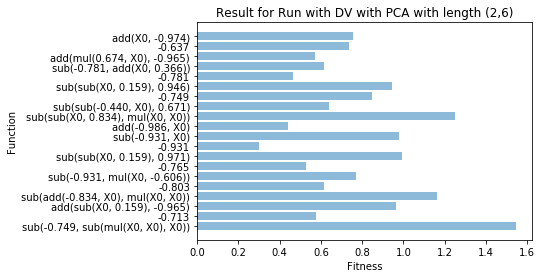

In [51]:
# Round the fitness to 3 decimal points for easy visualizaiton
list_of_rounded_fitness = []
for fitness in list_of_fitness:
    list_of_rounded_fitness.append(round(float(fitness),3))
objects = list_of_est_program
y_pos = np.arange(len(objects))
performance = list_of_rounded_fitness
plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.ylabel('Function')
plt.xlabel('Fitness')
plt.title('Result for Run with DV with PCA with length (2,6)')
 
plt.show()

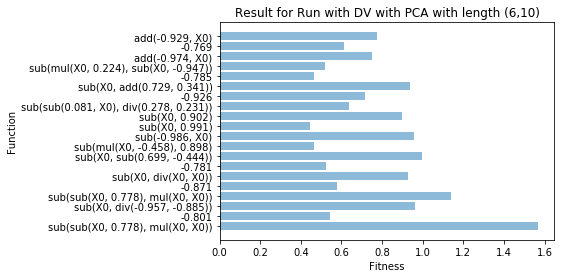

In [54]:
# Round the fitness to 3 decimal points for easy visualizaiton
list_of_rounded_fitness = []
for fitness in list_of_fitness:
    list_of_rounded_fitness.append(round(float(fitness),3))
objects = list_of_est_program
y_pos = np.arange(len(objects))
performance = list_of_rounded_fitness
plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.ylabel('Function')
plt.xlabel('Fitness')
plt.title('Result for Run with DV with PCA with length (6,10)')
 
plt.show()